<a href="https://colab.research.google.com/github/onelgo/onelgo/blob/main/h1n1_with_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBClassifier

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [ ]:
#import data
df_features = pd.read_csv('/content/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Features.csv', index_col="respondent_id")
df_labels = pd.read_csv('/content/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Labels.csv', index_col="respondent_id")
df_test = pd.read_csv('/content/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Test_Features.csv', index_col="respondent_id")
df_submission = pd.read_csv ('/content/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Submission_Format.csv', index_col="respondent_id")

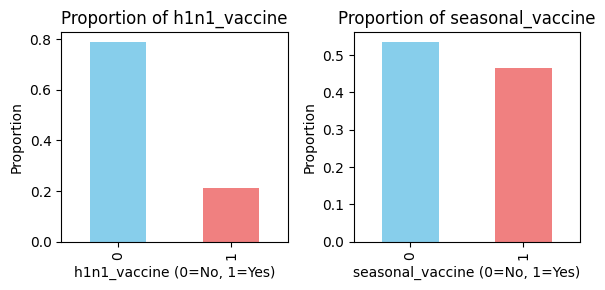

In [ ]:
#draw a graph displaying proportion of the label values

# Combine features and labels for easier analysis
df = pd.merge(df_features, df_labels, left_index=True, right_index=True)

# Calculate proportions for each label
h1n1_proportion = df['h1n1_vaccine'].value_counts(normalize=True)
seasonal_proportion = df['seasonal_vaccine'].value_counts(normalize=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot proportions for h1n1_vaccine
h1n1_proportion.plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Proportion of h1n1_vaccine')
axes[0].set_xlabel('h1n1_vaccine (0=No, 1=Yes)')
axes[0].set_ylabel('Proportion')

# Plot proportions for seasonal_vaccine
seasonal_proportion.plot(kind='bar', ax=axes[1], color=['skyblue', 'lightcoral'])
axes[1].set_title('Proportion of seasonal_vaccine')
axes[1].set_xlabel('seasonal_vaccine (0=No, 1=Yes)')
axes[1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

In [ ]:
#checking whether the two labels are independent
pd.crosstab(
    df_labels["h1n1_vaccine"],
    df_labels["seasonal_vaccine"],
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


Seems like there is a correlation. e.g. when they got h1n1 vaccine, they tend to also get seasonal vaccine (0.03 vs 0.17)

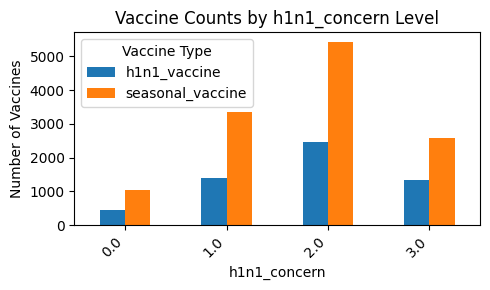

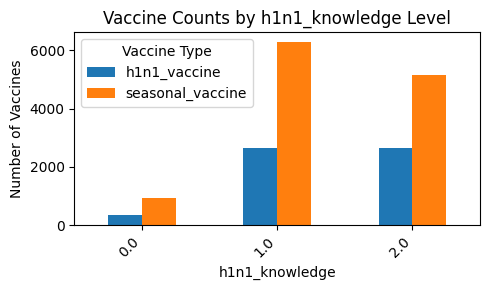

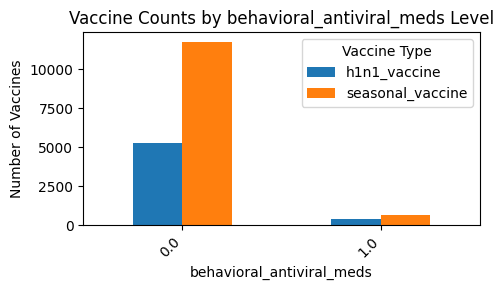

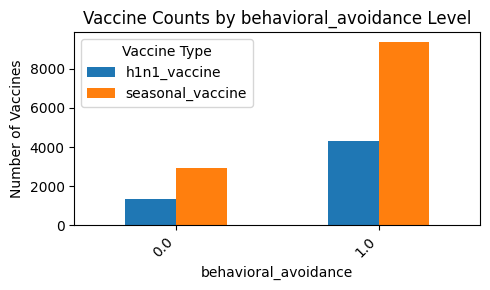

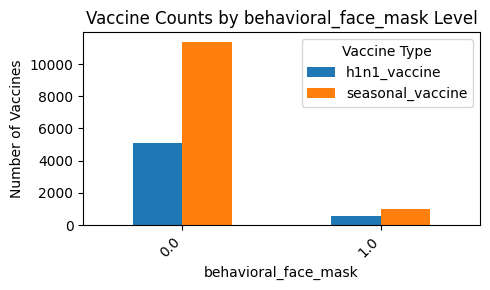

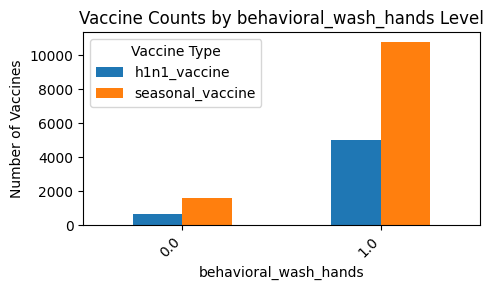

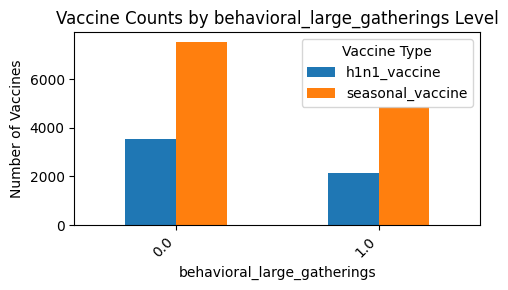

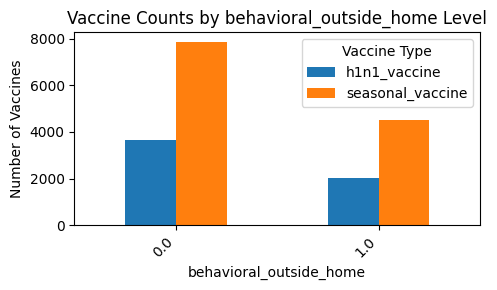

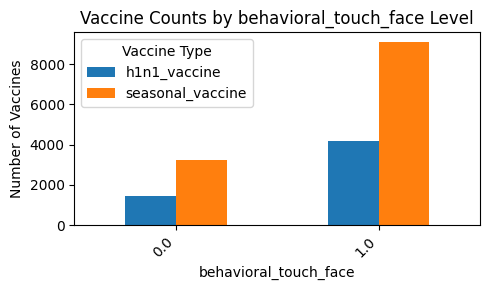

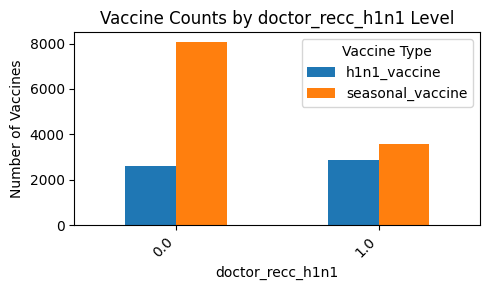

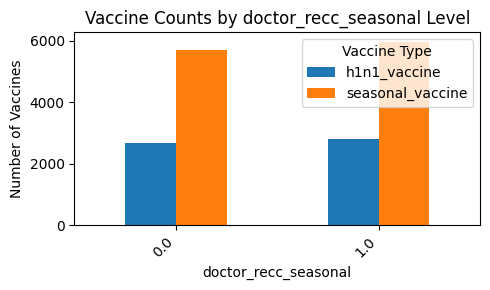

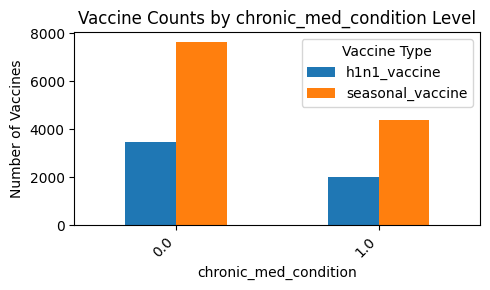

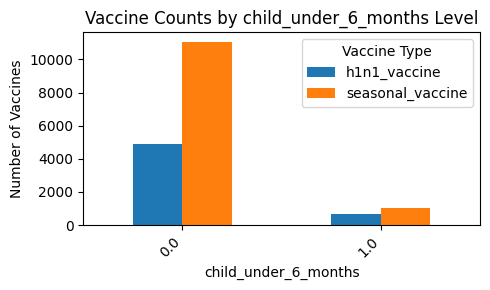

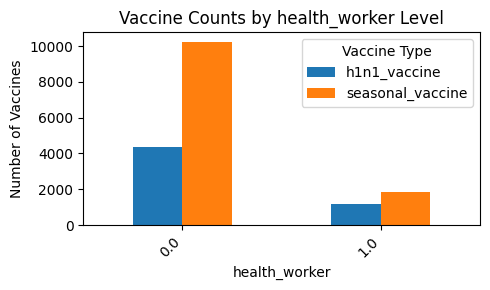

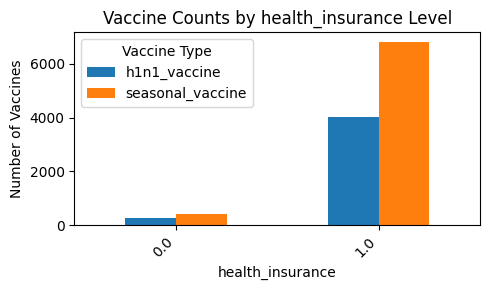

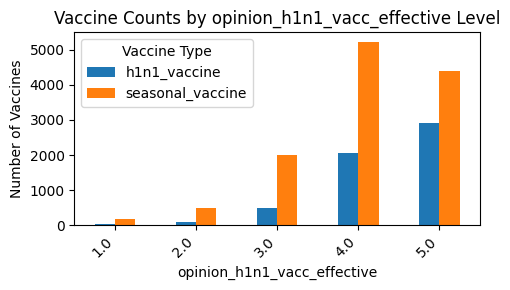

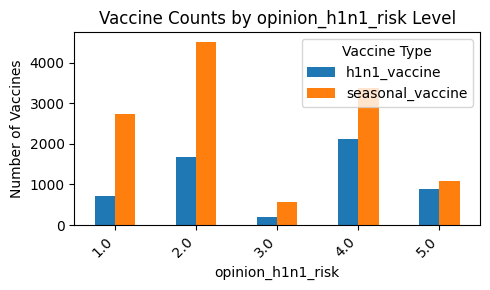

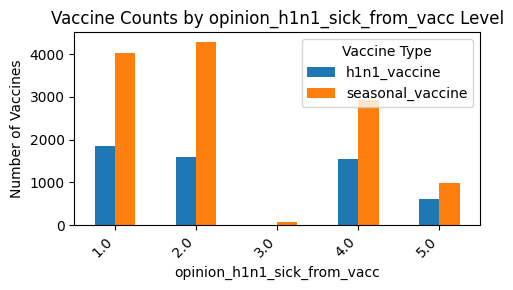

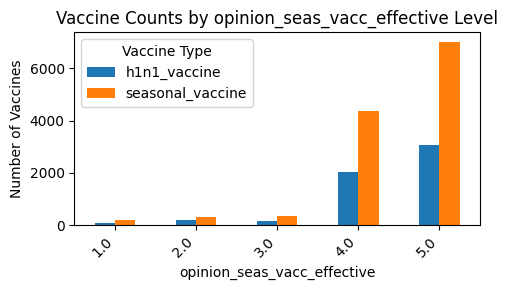

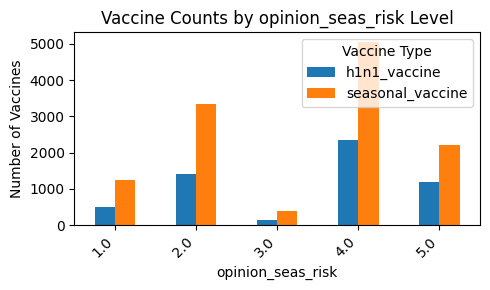

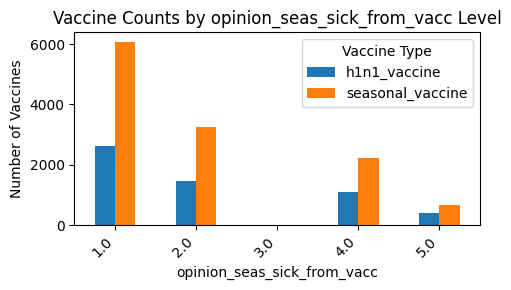

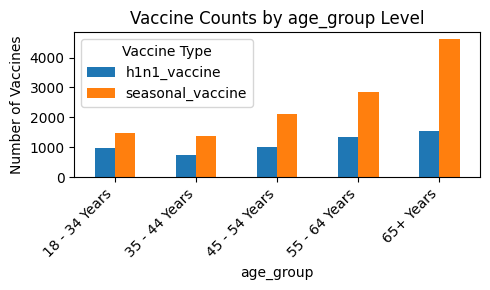

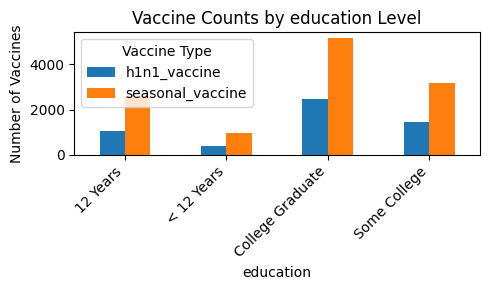

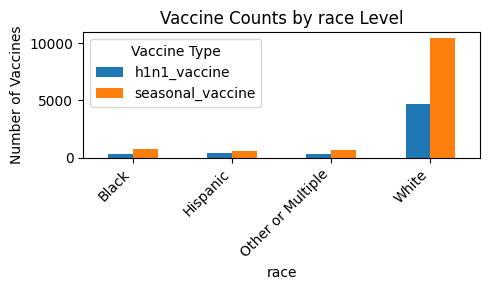

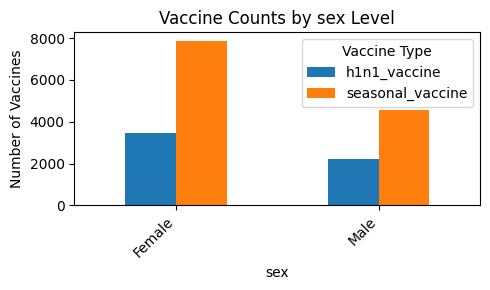

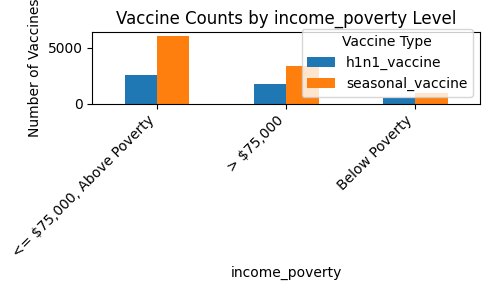

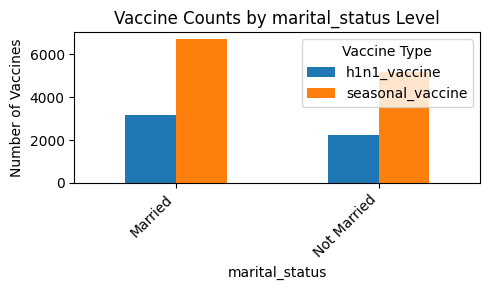

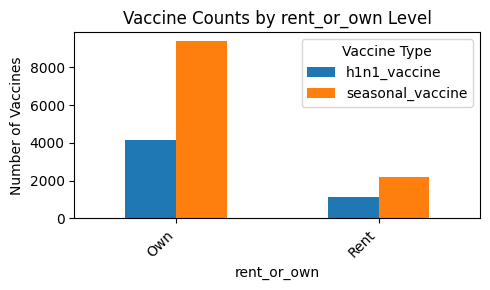

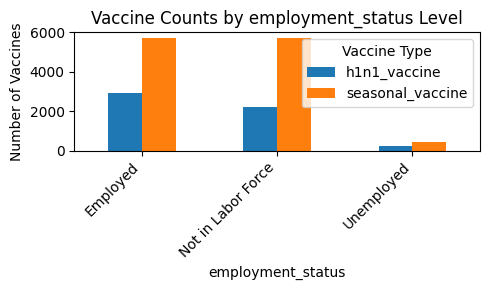

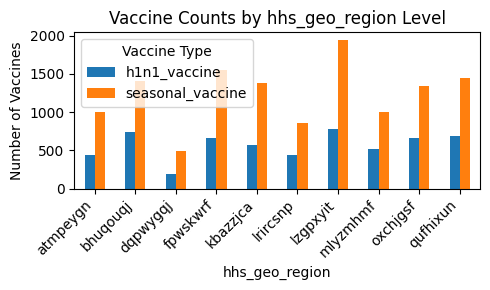

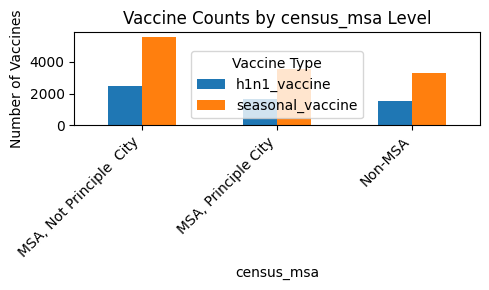

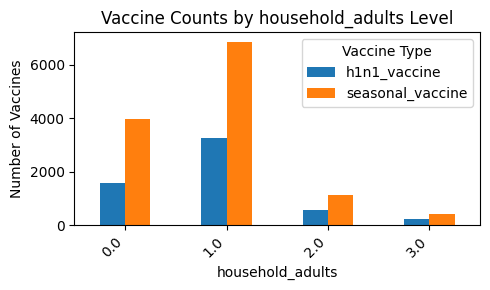

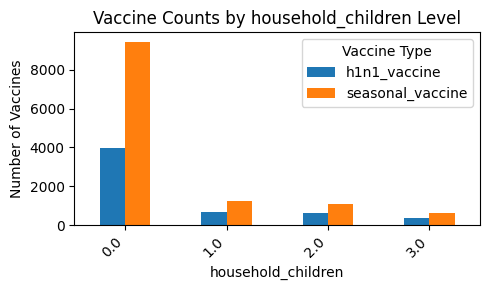

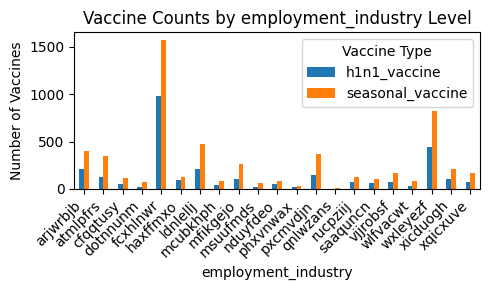

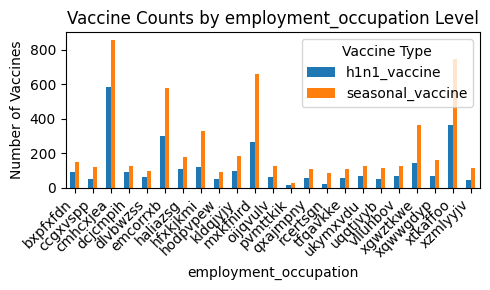

In [ ]:
# Create plots to check relationship between features and labels and potentially identify irrelevant features
for col in df_features.columns:
  # Group data by education and sum the vaccine counts
  vaccine_counts = df.groupby(col)[['h1n1_vaccine', 'seasonal_vaccine']].sum()

  plt.figure(figsize=(5, 3))

  # Create stacked bar plots
  vaccine_counts.plot(kind='bar', ax=plt.gca())
  plt.title(f'Vaccine Counts by {col} Level')
  plt.ylabel('Number of Vaccines')
  plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
  plt.legend(title='Vaccine Type')
  plt.tight_layout()
  plt.show()

In [ ]:
# dropping a column which doesn't seem to add any value based on the plots above
df_features = df_features.drop('doctor_recc_seasonal', axis=1)
df_features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [ ]:
cat_columns = df_features.select_dtypes(include='object').columns
num_columns = df_features.select_dtypes(exclude='object').columns
print(cat_columns)
print(num_columns)

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')
Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'health_insurance',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')


In [ ]:
#checking columns with more than 5% missing values and creating new indicator columns for missing values
for col in df_features.columns:
  na_frequency= (df_features[col].isna().sum() / len(df_features))*100
  if na_frequency > 4 and df_features[col].dtype=='float64':
    df_features[f'{col}_missing'] = df_features[col].isna().astype(int)
df_features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,doctor_recc_h1n1_missing,health_insurance_missing
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,1,1
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,1


In [ ]:
#build pipeline(s)
imputer = SimpleImputer(strategy="most_frequent")
polynomial = PolynomialFeatures(degree=2, include_bias=False) #polynomial terms for the numeric data help the model learn more non-linear relationships.
encoder = OneHotEncoder(drop='first')
scaler = MinMaxScaler()


estimators = {
    'logistic_reg': MultiOutputClassifier(LogisticRegression(max_iter=5000)),
    'random_forest': MultiOutputClassifier(RandomForestClassifier()),
    'xgboost': MultiOutputClassifier(XGBClassifier())
}


preprocessing_steps_cat = Pipeline([
     #('simple_imputer', imputer),
     ('one_hot_encoder', encoder)
      ])

preprocessing_steps_num = Pipeline([
    ('simple_imputer', imputer),
    ('polynomial', polynomial),
    ('min_max_scaler', scaler)
      ])

preprocessor = ColumnTransformer([
        ("categorical", preprocessing_steps_cat, cat_columns),
        ("numerical", preprocessing_steps_num, num_columns)
    ])

pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("estimator", estimators) #will be replaced with an estimator from param_grid
    ])

param_grid = [
    {
        'estimator': [MultiOutputClassifier(LogisticRegression(max_iter=5000))],
        'estimator__estimator__C': [0.01, 0.1, 1, 10]
    },

     {
        'estimator':[MultiOutputClassifier(RandomForestClassifier())],
        'estimator__estimator__n_estimators': [50, 100, 200],
        'estimator__estimator__max_depth': [None, 10, 20]
    },
    {
        'estimator': [MultiOutputClassifier(XGBClassifier())],
        'estimator__estimator__n_estimators': [50, 100, 200],
        'estimator__estimator__max_depth': [None, 10, 20]
    }
]

In [ ]:
# create model

X_train, X_val, y_train, y_val = train_test_split(df_features, df_labels, test_size=0.3, stratify=df_labels)

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=10)
grid_search.fit(X_train, y_train)

# evaluate the best model
best_model = grid_search.best_estimator_
print(f"Best Model: {best_model}")
y_pred = best_model.predict_proba(X_val)
y_pred_df = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[0][:, 1],
        "seasonal_vaccine": y_pred[1][:, 1],
    },
    index = y_val.index)
roc_auc = roc_auc_score(y_val, y_pred_df)
print(f"ROC AUC Score: {roc_auc}")

Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))...
       'child_under_6_months', 'health_worker', 'health_insurance',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object'))])),
                ('estimator',
                 MultiOutputClassifier(estimator=Log

Looks like the best one is Logistic Regression based on the above result

In [ ]:
#running the pipeline with the best model and parameters for the entire data set
pipeline_final = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", MultiOutputClassifier(LogisticRegression(C=0.1, max_iter=5000)))
    ])

pipeline_final.fit(df_features, df_labels)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))...
       'child_under_6_months', 'health_worker', 'health_insurance',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object'))])),
                ('estimator',
                 MultiOutputClassifier(estimator=LogisticRegression(C=0.1,
                                                                    max_iter=5000)))])

### Test dataset

In [ ]:
test_probas = pipeline_final.predict_proba(df_test)
test_probas

[array([[0.95907213, 0.04092787],
        [0.96561529, 0.03438471],
        [0.56085223, 0.43914777],
        ...,
        [0.88720733, 0.11279267],
        [0.95038213, 0.04961787],
        [0.48996053, 0.51003947]]),
 array([[0.71480616, 0.28519384],
        [0.95776044, 0.04223956],
        [0.22261754, 0.77738246],
        ...,
        [0.79295646, 0.20704354],
        [0.61628519, 0.38371481],
        [0.20812418, 0.79187582]])]

In [ ]:
df_submission['h1n1_vaccine'] = test_probas[0][:, 1]
df_submission['seasonal_vaccine'] = test_probas[1][:, 1]
df_submission.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.040928,0.285194
26708,0.034385,0.042240
26709,0.439148,0.777382
26710,0.573749,0.887314
26711,0.302420,0.587310


In [ ]:
df_submission.to_csv('my_submission_2.csv', index=True)
!head my_submission_2.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.040927870419498226,0.2851938391619993
26708,0.03438470689151468,0.04223955864597709
26709,0.4391477748757177,0.7773824617139131
26710,0.5737488814290017,0.8873144750780757
26711,0.3024203533653594,0.5873095404448009
26712,0.5142083371299985,0.9633934909144316
26713,0.3182345716082254,0.42455323825906904
26714,0.12701447199468538,0.2180159739904729
26715,0.04687118317509309,0.16780133876994086
